In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import numpy as np

In [ ]:
# Import results
f_path = "./results/"
files = [r for r in os.listdir(f_path) if ".csv" in r]
r_concat = pd.concat([pd.read_csv(f_path + f) for f in files])

# Debug
assert(len(r_concat) == len(pd.read_csv(f_path + files[0])) * len(files))

# Compute accuracy 
vs = "gt"
acc_noisy_bn = sum(r_concat[f"{vs}_mpes"] == r_concat["bn_noisy_mpes"]) / len(r_concat)
acc_cn = sum(r_concat[f"{vs}_mpes"] == r_concat["cn_mpes"]) / len(r_concat)

print(f"Accuracy noisy BN: {acc_noisy_bn:.3f}")
print(f"Accuracy CN: {acc_cn:.3f}", end="\n\n")

print(f"CN certainty: {sum(r_concat['cn_probs'] > 0.5) / len(r_concat):.3f}/1")

Accuracy noisy BN: 0.950
Accuracy CN: 0.987

CN certainty: 1.000/1


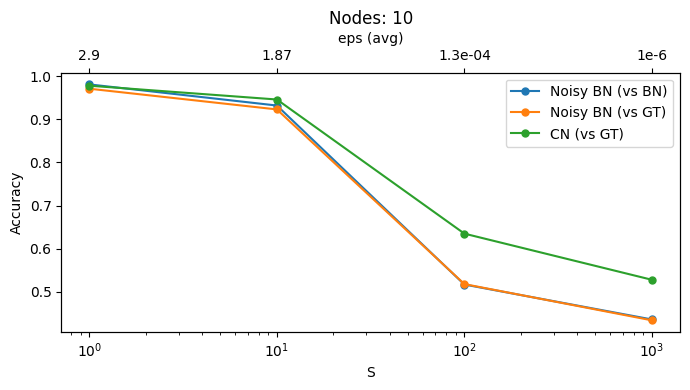

In [28]:
## Plot accuracy

# Data (10 nodes)
S_values = [1, 10, 100, 1000]
eps_labels = ["2.9", "1.87", "1.3e-04", "1e-6"]

acc_bn_noisy_gt = [0.971, 0.923, 0.518, 0.434]
acc_bn_noisy_bn = [0.981, 0.932, 0.517, 0.436]

acc_cn_gt = [0.978, 0.946, 0.635, 0.528]
# acc_cn_bn = [0.993, 0.949, 0.635, 0.528]

fig, ax = plt.subplots(figsize = (7, 4))

# Bottom x-axis
ax.semilogx(S_values, acc_bn_noisy_bn, marker='o', markersize = 5, label='Noisy BN (vs BN)')
ax.semilogx(S_values, acc_bn_noisy_gt, marker='o', markersize = 5, label='Noisy BN (vs GT)')

ax.semilogx(S_values, acc_cn_gt, marker='o', markersize = 5, label='CN (vs GT)')
# ax.semilogx(S_values, acc_cn_gt, marker='o', label='CN (vs BN)')

ax.set_xlabel('S')
ax.set_ylabel('Accuracy')
ax.set_xticks(S_values)

# Top x-axis in log scale
ax_top = ax.twiny()
ax_top.set_xscale('log')
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(S_values)
ax_top.set_xticklabels(eps_labels)
ax_top.tick_params(axis='x', which='minor', bottom=False, top=False)  # Disable minor ticks
ax_top.set_xlabel('eps (avg)')

# Legend
ax.legend(loc='best')
ax.set_title("Nodes: 10")

# Show the plot
plt.tight_layout()
plt.show()

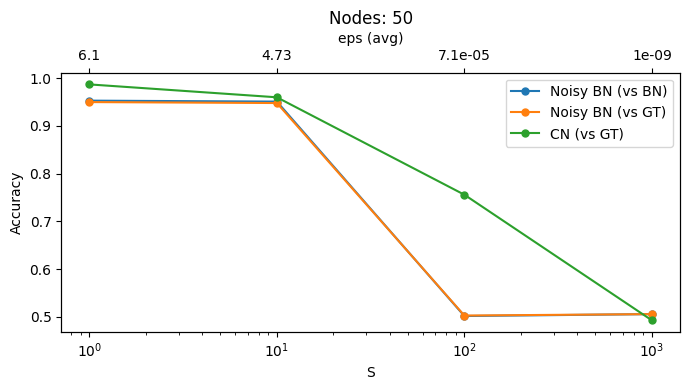

In [29]:
# Data (50 nodes)
S_values = [1, 10, 100, 1000]
eps_labels = ["6.1", "4.73", "7.1e-05", "1e-09"]

acc_bn_noisy_gt = [0.950, 0.948, 0.503, 0.506]
acc_bn_noisy_bn = [0.953, 0.951, 0.502, 0.506]

acc_cn_gt = [0.987, 0.960, 0.756, 0.493]
# acc_cn_bn = [0.994, 0.960, 0.754, 0.492]


fig, ax = plt.subplots(figsize = (7, 4))

# Bottom x-axis
ax.semilogx(S_values, acc_bn_noisy_bn, marker='o', markersize = 5, label='Noisy BN (vs BN)')
ax.semilogx(S_values, acc_bn_noisy_gt, marker='o', markersize = 5, label='Noisy BN (vs GT)')

ax.semilogx(S_values, acc_cn_gt, marker='o', markersize = 5, label='CN (vs GT)')
# ax.semilogx(S_values, acc_cn_gt, marker='o', label='CN (vs BN)')

ax.set_xlabel('S')
ax.set_ylabel('Accuracy')
ax.set_xticks(S_values)

# Top x-axis in log scale
ax_top = ax.twiny()
ax_top.set_xscale('log')
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(S_values)
ax_top.set_xticklabels(eps_labels)
ax_top.tick_params(axis='x', which='minor', bottom=False, top=False)  # Disable minor ticks
ax_top.set_xlabel('eps (avg)')

# Legend
ax.legend(loc='best')
ax.set_title("Nodes: 50")

# Show the plot
plt.tight_layout()
plt.show()

In [30]:
# ROC curve
# TODO